In [1]:
import psycopg2
import pandas as pd
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pytz
import pandas_ta as ta
import plotly.express as px
import plotly.graph_objects as go
import itertools
import random
from da_controller import *
from strategies import *
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from typing import Dict, List, Any
from optimizers import GeneticOptimizer, GridSearchOptimizer

controllers_path = os.path.abspath("../historic_updater")
sys.path.append(controllers_path)
from controllers import *

# READ DF
data_path = os.path.abspath("../data")
sys.path.append(data_path)
file_name = 'BTCUSDT_futures_15m_2024-12-01_2025-03-02.csv'
data_filepath = os.path.join(data_path, file_name)
df = pd.read_csv(data_filepath)
df = format_df(df)
df = df.reset_index(drop=True)
strategy = EMADXRSI_scalping_strategy

In [2]:
# Genetic optimization
# Input values
long_EMA_range = range(10, 101, 5)
trend_range_range = range(10, 501, 10)
trend_threshold_range = np.arange(0.01, 1.1, 0.01)
support_range_range = range(10, 701, 10)
support_chance_range = np.arange(0.01, 1.1, 0.01)
ADX_thresh_range = range(15, 31, 1)
ADX_period_range = range(5, 26, 1)
RSI_period_range = range(5, 26, 1)
RSI_overbought_range = range(60, 101, 1)
RSI_oversold_range = range(0, 41, 1)
max_wait_range = range(1, 15, 1)



key_range = {
    'long_EMA': long_EMA_range,
    'trend_range': trend_range_range,
    'trend_threshold': trend_threshold_range,
    'support_range': support_range_range,
    'support_chance': support_chance_range,
    'ADX_thresh': ADX_thresh_range,
    'ADX_period': ADX_period_range,
    'RSI_period': RSI_period_range,
    'RSI_overbought': RSI_overbought_range,
    'RSI_oversold': RSI_oversold_range,
    'max_wait': max_wait_range
}

def fitness_function(population):
    fitness_values = []
    for individual in population:
        result = true_backtest(df, strategy, trade_comission=0.001,**individual)
        fitness_values.append(result)
    return fitness_values


# Grid search implementation
optimizer = GeneticOptimizer(
    parameter_ranges=key_range,
    population_size=50,
    elite_size=5,
    mutation_rate=0.2,
    tournament_size=3
)

best_params, best_fitness, fitness_history, diversity_history = optimizer.optimize(
    fitness_function=lambda pop: fitness_function(pop),
    n_generations=100,
    min_diversity=0.4
)

print(f"\nBest parameters: {best_params}")

Restarting population at generation 1839 - Diversity: 0.57
Restarting population at generation 4205 - Diversity: 0.55
Restarting population at generation 7415 - Diversity: 0.52
Restarting population at generation 9547 - Diversity: 0.53
Generation 99/100 - Best Fitness: 132.47 - Diversity: 0.55
Best parameters: {'long_EMA': 50, 'trend_range': np.int64(30), 'trend_threshold': np.float64(1.05), 'support_range': 270, 'support_chance': np.float64(0.11900000000000001), 'ADX_thresh': 26, 'ADX_period': 12, 'RSI_period': 12, 'RSI_overbought': 68, 'RSI_oversold': 24, 'max_wait': 7}


Final funds: 132.4714533239696
Total trades: 3
Win trades: 3
Lose trades: 0
Max trade rate: 1.1702241201045342
Min trade rate: 1
Max win streak: 3
Max lose streak: 0
Max drawdown: 100


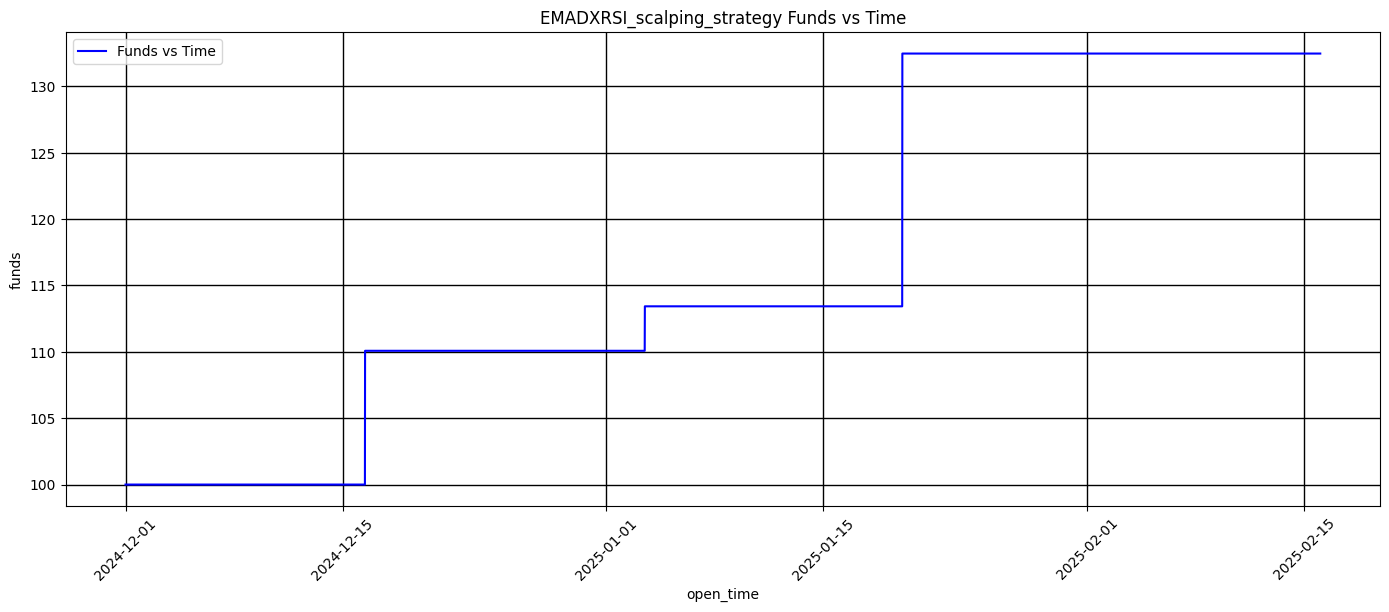

In [4]:
values = best_params
detailed_true_backtest(df, strategy, **values)

In [49]:
plot_strategy_signals(df, strategy,**best_params)

Final funds: 116.82557293820534
Total trades: 61
Win trades: 37
Lose trades: 24
Max trade rate: 1.0588014869316982
Min trade rate: 0.9354034195765706
Max win streak: 6
Max lose streak: 2
Max drawdown: 100


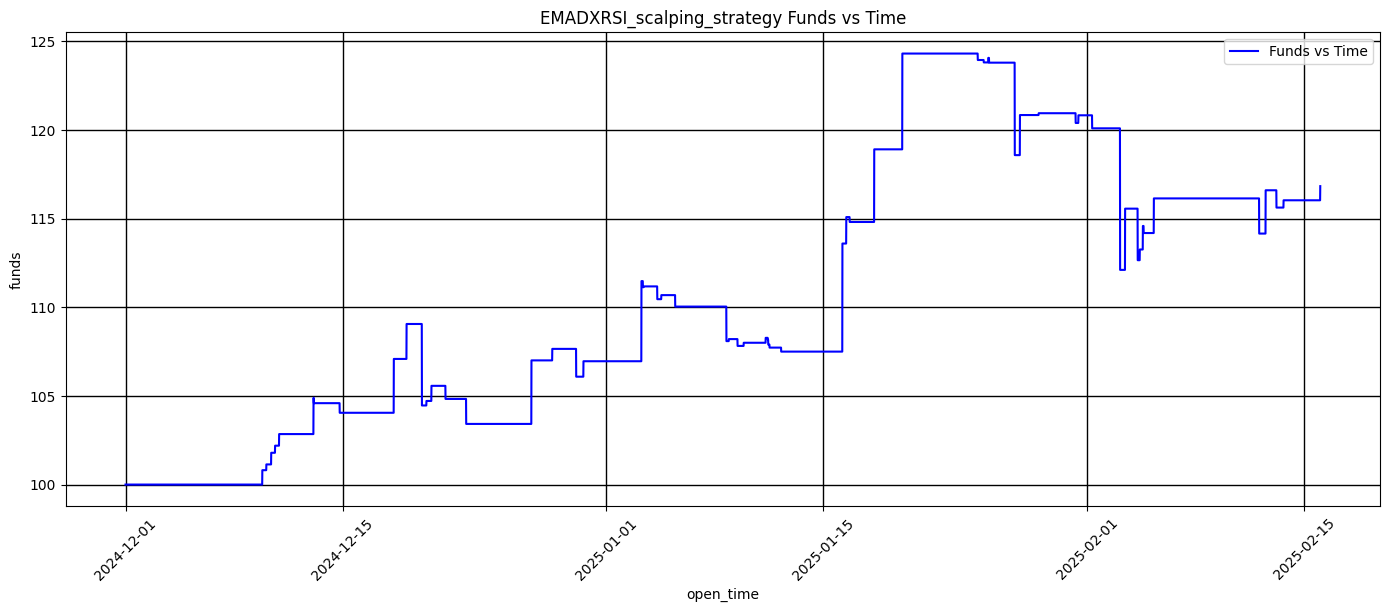

In [6]:
long_EMA=50
trend_range=50 
trend_threshold=0.5
support_range=500
support_chance=0.01
ADX_thresh=30 
ADX_period=5
RSI_period=3 
RSI_overbought=80 
RSI_oversold=20
vol_sma_period=20
max_wait=5

values = {
    'long_EMA': long_EMA,
    'trend_range': trend_range,
    'trend_threshold': trend_threshold,
    'support_range': support_range,
    'support_chance': support_chance,
    'ADX_thresh': ADX_thresh,
    'ADX_period': ADX_period,
    'RSI_period': RSI_period,
    'RSI_overbought': RSI_overbought,
    'RSI_oversold': RSI_oversold,
    'max_wait': max_wait
}
detailed_true_backtest(df, strategy, **values)

In [7]:
plot_strategy_signals(df, strategy,**values)

Final funds: 104.2216626731105
Total trades: 1
Win trades: 1
Lose trades: 0
Max trade rate: 1.042216626731105
Min trade rate: 1
Max win streak: 1
Max lose streak: 0
Max drawdown: 100


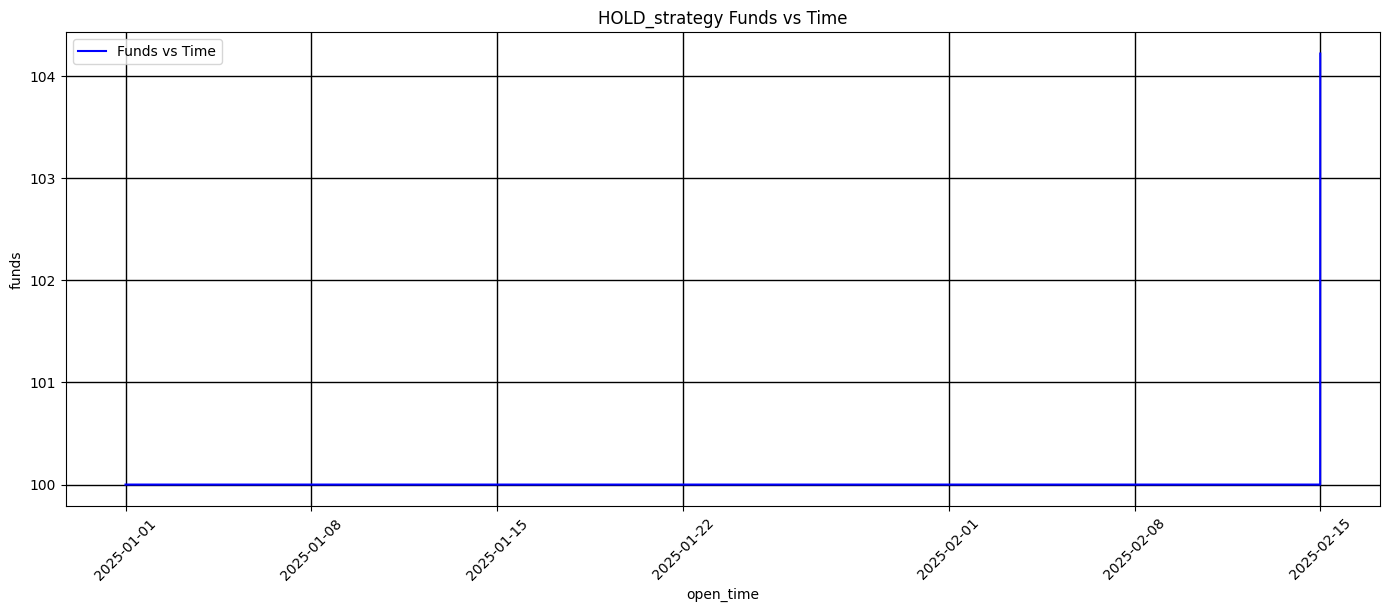

In [6]:
values = {}
detailed_backtest(df, HOLD_strategy, **values)